# Pokémon dataset generation

In this notebook, we will see how to build the `pkmn_dataset` used for training [Neural Weighted A*](https://arxiv.org/abs/2105.01480).

The idea is to extract from random Pokémon maps non-trivial source-target pairs. Each map corresponds to a weighted graph in the 8-GridWorld setting, and source-target pairs constitute planning problems on such graphs. This notebook handles the random map creation and the source-target extraction.

Here is an example of what this notebook can generate: a random Pokémon map, the associated graph costs, and a source-target pair.

![Map sample](https://raw.githubusercontent.com/archettialberto/tilebased_navigation_datasets/main/samples/pkmn_map_sample.png)
![Map sample](https://raw.githubusercontent.com/archettialberto/tilebased_navigation_datasets/main/samples/pkmn_cost_sample.png)
![Map sample](https://raw.githubusercontent.com/archettialberto/tilebased_navigation_datasets/main/samples/pkmn_st_sample.png)

The dataset has been created with [Google Colab](https://colab.research.google.com/).

## Download zip

First, download the `rnd_pkmn_maps.zip` file.

This file contains 
* 9 random Pokémon maps generated using [Cartographer Alpha](https://www.pokecommunity.com/showthread.php?t=429142) from which the smaller maps will be extracted,
* 563 tiles **manually** split into the following tile types: *dirt*, *grass*, *lake*, *leaves*, *mud*, *ocean*, *plants*, *sand*, *snow*, *stairs*, and *wall*.

The 563 tiles do not constitute the entire tile set of the bigger maps, as tile classification by hand is quite boring! I noticed that many tiles differ only by a handful of boundary pixels. I was able to reduce the total number of tiles to be classified by ignoring a 4-pixel margin of each tile. More on that in the `CostGenerator` class.

In [ ]:
!wget -q https://www.dropbox.com/s/pw4d2ieuwtzjpg0/rnd_pkmn_maps.zip 
!unzip -qq rnd_pkmn_maps.zip

## Generate maps

Let's build a random (map, costs) generator. Each map should be valid, i.e.,
* the same tile should not appear too often,
* it must have a big area not separated by walls.

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import itertools
import shutil
from tqdm.notebook import tqdm  # tqdm for Google Colab users
# from tqdm import tqdm  # tqdm for non Google Colab users
import cv2
from scipy import ndimage


# PIL does not like very big images
Image.MAX_IMAGE_PIXELS = None

np.random.seed(0)

In [ ]:
def show(img, title=""):
    if title != "":
        plt.title(title)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
class MapGenerator:
    def __init__(self, tile_shape, maps_dir="maps"):
        """
        Map crop iterator. At each call it returns a unique random map crop.

        tile_shape : (int, int)
            number of tiles for each crop
        """ 
        self.maps = []
        for f in os.listdir(maps_dir):
            self.maps.append(Image.open(os.path.join(maps_dir, f)))
        self.tile_shape = tile_shape
        self.tile_px = (16, 16)

    def __iter__(self):
        # we want each tile to be unique!
        self.taken = set()
        return self
    
    def __next__(self):
        # pick a random map
        map_idx = np.random.randint(0, len(self.maps))
        map = self.maps[map_idx]
        # select a map crop
        crop_pt = (
            np.random.randint(0, map.size[0] // self.tile_px[0] - 1),
            np.random.randint(0, map.size[1] // self.tile_px[1] - 1)
        )
        # is the crop already taken?
        if (map_idx, crop_pt) in self.taken:
            return self.__next__()
        self.taken.add((map_idx, crop_pt))
        x_cr = crop_pt[0] * self.tile_px[0]
        y_cr = crop_pt[1] * self.tile_px[1]
        xx_cr = x_cr + self.tile_px[0] * self.tile_shape[0]
        yy_cr = y_cr + self.tile_px[1] * self.tile_shape[1]
        # return the map crop
        return map.crop((x_cr, y_cr, xx_cr, yy_cr))

In [ ]:
class CostsGenerator:
    """
    Generates graph costs from a map crop.

    costs_dict : dict
        dictionary connecting tiles (ignoring a 4 pixel margin) to a real-valued
        cost
    """
    def __init__(self, costs_dict, tiles_dir="tiles"):
        self.costs_dict = costs_dict
        self.tile_px = (16, 16)
        self.tiles_dict = {}
        # load, cut, and hash tiles, then build a tile hash dictionary
        for key in self.costs_dict.keys():
            for f in os.listdir(os.path.join(tiles_dir, key)):
                img = Image.open(os.path.join(tiles_dir, key, f))
                half_crop = self._cut_half_tile(img, (0, 0))
                hash_crop = self._tile_to_str(half_crop)
                self.tiles_dict[hash_crop] = self.costs_dict[key]
    
    def _cut_half_tile(self, img, tile_pos):
        # cuts the 4 pixel margin of the input image
        x, y = tile_pos
        img = img.convert("RGB")
        return img.crop((x * self.tile_px[0] + self.tile_px[0] // 4,
                         y * self.tile_px[1] + self.tile_px[1] // 4,
                         (x + 1) * self.tile_px[0] - self.tile_px[0] // 4,
                         (y + 1) * self.tile_px[1] - self.tile_px[1] // 4))

    def _tile_to_str(self, img):
        # we need to convert images into strings to use them as key values in a 
        # Python dictionary
        img_np = np.asarray(img)
        return np.array_str(img_np)
    
    def generate(self, img):
        # use self.tiles_dict to map tiles to costs, then return the numpy array
        x_tiles = img.size[0] // self.tile_px[0]
        y_tiles = img.size[1] // self.tile_px[1]
        costs = np.zeros((x_tiles, y_tiles), dtype=np.float32)
        for x, y in itertools.product(range(x_tiles), range(y_tiles)):
            half_crop = self._cut_half_tile(img, (y, x))
            hash_crop = self._tile_to_str(half_crop)
            costs[x, y] = self.tiles_dict[hash_crop]
        return costs
    
    def tile_frequency(self, costs):
        # evaluate the frequency of each tile type in the input cost array
        freq = {}
        for key, cost in self.costs_dict.items():
            freq[key] = round(np.mean(costs == cost), 5)
        return freq

In [ ]:
class CostsFilter:
    """
    Selects which cost arrays are valid.

    map_generator : MapGenerator
        generates random map crops
    
    cost_generator : CostsGenerator
        handles tile-to-cost mappings
    
    max_freq_dict : dict
        for each tile type, it defines the maximum frequency in which the tile 
        can appear in a valid cost array
    
    connectivity_thr : float in (0, 1]
        for each map crop, it defines the minumum percentage of map surface that
        must be connected (i.e., not separated by walls)
    """
    def __init__(self, map_generator, costs_generator, max_freq_dict, 
                 connectivity_thr):
        self.mg = iter(map_generator)
        self.cg = costs_generator
        self.max_freq_dict = max_freq_dict
        self.connectivity_thr = connectivity_thr
    
    def __iter__(self):
        return self
    
    def __next__(self):
        # generated a valid (map crop, map costs) pair
        while True:
            try:
                m = next(self.mg)
                cost = self.cg.generate(m)
                if self._is_valid(cost):
                    return m, cost
            except KeyError:
                pass
    
    def _is_valid(self, cost):
        # check if tile frequencies are ok
        freq = self.cg.tile_frequency(cost)
        for key in self.max_freq_dict:
            if freq[key] > self.max_freq_dict[key]:
                return False

        # check if there's at least one connected component covering at least
        # the [connectivity_thr] percentage of the map
        walls_mask = 255 - np.equal(
            cost, self.cg.costs_dict["wall"]
        ).astype(np.uint8) * 255
        l_num, labels = cv2.connectedComponents(walls_mask, connectivity=8)
        ret = False
        for z in range(l_num):
            if z > 0 and ret is False:
                if np.mean(labels == z) > self.connectivity_thr:
                    ret = True
        return ret

In [ ]:
# maps each of the 11 tile types to a real-valued cost; the wall cost is 
# special, as it defines tiles that should not be traversable
costs_dict = {
    'dirt': 2.0,
    'grass': 1.5,
    'lake': 6.0,
    'leaves': 2.5,
    'mud': 8.0,
    'ocean': 10.0,
    'plants': 3.5,
    'sand': 1.0,
    'snow': 1.8,
    'stairs': 1.0,
    'wall': 25.0,
}

# defines the maximum appearance percentage in a valid map crop for each tile 
# type
max_freq_dict = {
    'dirt': .9,
    'grass': .9,
    'lake': .9,
    'leaves': .9,
    'mud': .9,
    'ocean': .7,
    'plants': .9,
    'sand': .9,
    'snow': .9,
    'stairs': .9,
    'wall': .7,
}

# defines the minimum connected percentage of a map crop to be considered valid
connectivity_thr = .4

# defines the number of row-column tiles for each map crop
tile_shape = (20, 20)

m_gen = MapGenerator(tile_shape)
w_gen = CostsGenerator(costs_dict)
w_filter = CostsFilter(m_gen, w_gen, max_freq_dict, connectivity_thr)

# and finally we have a valid (map crop, costs) iterator
iterator = iter(w_filter)

In [ ]:
# how many (map crop, costs) pairs you want?
num_maps = 10

# let's save maps and costs in the data/ folder
os.makedirs("data", exist_ok=True)
for count in tqdm(range(num_maps)):
    m, c = next(iterator)
    np.save("data/m_{:d}.npy".format(count), np.asarray(m).astype(np.uint8))
    np.save("data/c_{:d}.npy".format(count), c)

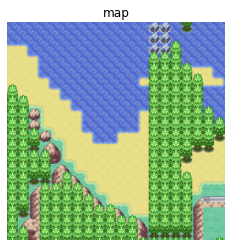

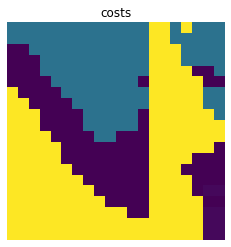

In [ ]:
idx = np.random.randint(0, num_maps)

m = np.load("data/m_{:d}.npy".format(idx))
c = np.load("data/c_{:d}.npy".format(idx))

show(m, title="map")
show(c, title="costs")

## Sample (source point, target point) pairs

Let's sample source and target points from (map, costs) pairs. We require these points to be reasonably far away from each other.

In [ ]:
class JourneyManager:
    """
    Generates (source point, target point) pairs for (map, costs) pairs.

    t_per_i : int
        target points to be sampled for each (map, costs) pair
    
    s_per_t : int
        source points to be sampled for each target point
    
    wall_cost : float
        cost value of wall tiles
    
    connectivity_thr : float in (0, 1]
        for each map crop, it defines the minumum percentage of map surface that
        must be connected (i.e., not separated by walls)
    
    steps_thr : int
        minimum number of steps separating source and target points
    """
    def __init__(self, t_per_i, s_per_t, wall_cost=25.0, 
                 connectivity_thr=.4, steps_thr=15):
        self.t_per_i = t_per_i
        self.s_per_t = s_per_t
        self.wall_cost = wall_cost
        self.connectivity_thr = connectivity_thr
        self.steps_thr = steps_thr
        self.kernel = ndimage.generate_binary_structure(2, 2)
    
    def sample_st(self, costs):
        # returns a dictionary mapping a target position to a list of source 
        # positions

        # detect which connected components are "big enough"
        walls_mask = np.equal(costs, self.wall_cost).astype(np.uint8)
        l_num, labels = cv2.connectedComponents(1 - walls_mask, connectivity=8)
        valid_labels = []
        for z in range(l_num):
            if z > 0 and np.mean(labels == z) > self.connectivity_thr:
                valid_labels.append(z)
        
        # evaluate (source, target) pairs
        journeys = {}
        while len(journeys.keys()) < self.t_per_i:
            # extract a unique target point for a random valid connected 
            # component
            label = valid_labels[np.random.randint(0, len(valid_labels))]
            x_l, y_l = np.where(labels == label)
            idx = np.random.randint(0, len(x_l))
            t = (x_l[idx], y_l[idx])
            if t in journeys.keys():
                continue
            
            # evaluate the Chebyshev distance (number of steps considering 
            # diagonals) between the target point and each other point in the 
            # map, then identify the set of points at the correct distance from
            # the target
            steps = np.zeros_like(costs).astype(np.uint8)
            steps[t[0], t[1]] = 1
            for _ in range(self.steps_thr):
                _steps = ndimage.binary_dilation(steps, structure=self.kernel)
                steps = (steps + _steps) * (1 - walls_mask)
            other_regions = (labels != label).astype(np.uint8)
            valid_region = other_regions + walls_mask + steps
            x_l, y_l = np.where(valid_region == 0)
            if len(x_l) == 0:
                continue
            
            # sample the set of sources from the valid map region
            sources = []
            for _ in range(25):
                if len(sources) < self.s_per_t:
                    idx = np.random.randint(0, len(x_l))
                    s = (x_l[idx], y_l[idx])
                    if s not in sources:
                        sources.append(s)
            if len(sources) < self.s_per_t:
                continue
            journeys[t] = sources

        return journeys

In [ ]:
# defines the arguments for source-target sampling
sampler_args = {
    't_per_i': 1,
    's_per_t': 1,
    'wall_cost': costs_dict["wall"],
    'connectivity_thr': connectivity_thr,
    'steps_thr': int(tile_shape[0] * 0.6)
}

jm = JourneyManager(**sampler_args)

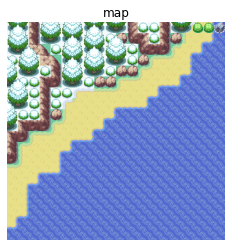

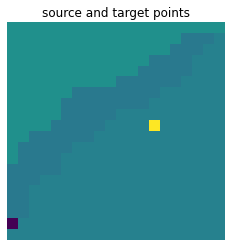

In [ ]:
idx = np.random.randint(0, num_maps)
m = np.load("data/m_{:d}.npy".format(idx))
c = np.load("data/c_{:d}.npy".format(idx))
show(m, title="map")
j = jm.sample_st(c)

for t in j.keys():
    for s in j[t]:
        _c = c.copy() / np.max(c) * 0.1 + 0.4
        _c[s[0], s[1]] = 0.0
        _c[t[0], t[1]] = 1.0
        show(_c, title="source and target points")